# **CA 2, LLMs Spring 2025**

- **Name:** _Moho Barabadi_
- **Student ID:** _810199383_

## Preliminaries

In [ ]:
%pip install --upgrade pip && pip install "unsloth[cu124-torch260] @ git+https://github.com/unslothai/unsloth.git"


In [ ]:
%pip install datasets Levenshtein trl

In [ ]:
import unsloth
print(unsloth.__version__)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
2025.3.19


In [ ]:
import torch
import numpy as np
import re
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from Levenshtein import ratio
from collections import defaultdict
from datasets import load_dataset
from trl import ORPOConfig, ORPOTrainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
from google.colab import userdata
!huggingface-cli login --token {userdata.get('HuggingfaceToken')}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `LLM` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `LLM`


In [ ]:
class CONFIG:
    seed = 42
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # keep the same 4‑bit base
    model_name = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
    reward_model_name = "nicolinho/QRM-Llama3.1-8B-v2"
    dataset_name = "mlabonne/orpo-dpo-mix-40k"

    # cut dataset in half
    train_data_size = 800
    benchmark_subset_size = 50

    # shorten sequences
    max_seq_length = 1024   # down from 2048
    # you can even try 512 if things still OOM

    # micro‑batch sizing
    train_batch_size = 1    # down from 2
    gradient_accumulation_steps = 8  # up from 4 → keeps effective batch=8

    # 1 epoch to save on training time & memory
    epochs = 1

    # lighter LoRA
    lora_rank = 32         # down from 64
    lora_alpha = 32        # down from 64
    use_gradient_checkpointing = "unsloth"
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        # you can also drop gate_proj/up_proj/down_proj if still tight
    ]

    dpo_output_dir = "llama-3.2-3b-dpo-checkpoint"
    orpo_output_dir = "llama-3.2-3b-orpo-checkpoint"


# In-context Learning (30 Points)




### Question 1 (5 points):

**a)** What is In-Context Learning (ICL), and how does it differ from fine-tuning? What are its limitations compared to fine-tuning?

**b)** Explain what [Chain-of-Thought (CoT)](https://arxiv.org/abs/2201.11903) prompting is and how it works.

##a)
### In-Context Learning (ICL)
- Allows language models to perform tasks based on examples and instructions in the prompt without weight updates
- Model identifies patterns from demonstrations at inference time

### ICL vs. Fine-tuning
- ICL: Changes prompt only; happens at inference; limited by context window; reuses one model; higher inference cost; more sensitive to prompt variations; no data storage
- Fine-tuning: Updates model weights; happens offline; handles unlimited data; usually needs one checkpoint per task; higher training cost; more stable inference; may memorize training data

### ICL Limitations
- Context window constraints
- Higher per-query costs
- Unstable performance with prompt changes
- No knowledge retention between sessions
- Harder to ensure compliance or style
- Less effective for small/medium models

### When to Use Which
- ICL: Quick prototyping, limited examples, when data retention is risky
- Fine-tuning: Long-term products, large datasets, regulatory requirements, when stability matters

ICL is "training at inference via the prompt" - good for fast iteration but limited in scale and stability. Fine-tuning changes parameters to handle more data and provide cheaper, consistent production performance, but requires more resources and complexity.

##b)

Chain-of-Thought prompting is a technique that encourages large language models to break down complex reasoning into explicit steps before providing an answer.

### How it works
- Include phrases like "Let's think step by step" in your prompt
- The model then shows its reasoning process in natural language
- This helps the model arrive at more accurate answers for complex problems

### Types:
- **Zero-shot CoT**: Simply add "Let's think step by step" to your prompt
- **Few-shot CoT**: Include examples showing both questions and step-by-step answers

### Benefits
- Significantly improves performance on math, reasoning, and logic tasks
- Provides transparency into the model's thinking process
- Works particularly well with larger models (100B+ parameters)
- Requires no additional training or fine-tuning

### Limitations:
- Less effective with smaller models
- Produces longer outputs (higher token usage)
- May still contain reasoning errors or hallucinations

CoT has become a fundamental technique for improving LLM performance on complex reasoning tasks since its introduction in 2022.

### Load Model & Tokenizer (2.5 points)

- Load `Llama-3.2-3B-Instruct-bnb-4bit` model using `unsloth` for inference.

In [ ]:
from unsloth import FastLanguageModel

def load_model_and_tokenizer(model_id, max_seq_length):
    print("Loading model and tokenizer using unsloth...")
    # Load the model and tokenizer using FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_id,
        max_seq_length=max_seq_length,
         dtype=None,  # Auto-detect dtype
         load_in_4bit=True,  # Use 4-bit quantization
    )

    return model, tokenizer

In [ ]:
model, tokenizer = load_model_and_tokenizer(CONFIG.model_name, CONFIG.max_seq_length)

Loading model and tokenizer using unsloth...
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

### Load benchmark (2.5 points)

1. Load the `GSM8K` benchmark dataset.
2. Randomly select a subset of `50` samples from the dataset.
3. Display one sample from the selected subset.
<a id="gsm8k_benchmark"></a>

In [ ]:
def load_gsm8k_dataset():
    """Load the GSM8K dataset from HuggingFace."""
    dataset = load_dataset(CONFIG.benchmark_name, 'main')
    return dataset

def create_sample_dataset(dataset, num_samples, seed):
    """Create a fixed sample dataset for evaluation."""
    # Set seed for reproducibility
    np.random.seed(seed)

    # Get test split
    test_data = dataset["test"]

    # Select random samples
    indices = np.random.choice(len(test_data), num_samples, replace=False)
    sample_test = test_data.select(indices)

    return sample_test

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
dataset = load_gsm8k_dataset()

# Select subset
sample_dataset = create_sample_dataset(dataset, num_samples=CONFIG.benchmark_subset_size, seed=CONFIG.seed)

# Display one sample
sample_idx = 0
sample = sample_dataset[sample_idx]
print(f"\nQuestion: {sample['question']}")
print(f"\nAnswer: {sample['answer']}")

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]


Question: Carol and Jennifer are sisters from Los Angeles who love collecting signatures from celebrities. During their summer break from school, the sisters spend every afternoon collecting signatures. After five weeks, Carol and Jennifer compare their autograph books, counting up the number of signatures each sister has collected. Carol has 20 signatures in her book, and Jennifer has 44. The sisters have three more weeks of summer vacation, and they decide they want to reach 100 signatures between them by the end of the summer. How many signatures do the sisters need to collect to reach their goal?

Answer: Carol and Jennifer have already collected 20 + 44 signatures = <<20+44=64>>64 signatures.
Since their goal is 100, they need to collect 100 - 64 signatures. 100 - 64 = <<100-64=36>>36 signatures
#### 36


### Prompt Engineering (10 points)

Implement different prompting strategies for in-context learning.
At least four of the following methods should be implemented (including baseline):
- Zero-shot (**Baseline**)
- Role-play prompting [[paper](https://aclanthology.org/2024.naacl-long.228/)]
- Zero-shot CoT [[paper](https://arxiv.org/abs/2205.11916)]
- Few-shot CoT
- Least-to-Most prompting [[paper](https://arxiv.org/abs/2205.10625)]
- Generated Knowledge prompting [[paper](https://aclanthology.org/2022.acl-long.225/)]
- Any other idea to improve performance (**Optional**)

Additionally, if performance exceeds 80%, **two extra points** are awarded for every 5% improvement. You can try other methods or a combination of existing ones.

<a id="prompt-engineering"></a>

In [ ]:
def create_prompts(question, examples=None):
    """Generate various prompt types for a given question."""

    # Zero-shot (Baseline)
    zero_shot = (
        f"Problem: {question}"
        "\n\nThe answer number is "
    )

    # Role-play prompting
    role_prompting = (
        "You are a brilliant mathematician with expertise in solving mathematical word problems. "
        "You always think carefully and methodically to arrive at the correct answer.\n\n"
        f"Problem: {question}\n\n"
        "Please solve this step-by-step and calculate the final numerical answer."
    )

    # Zero-shot CoT
    zero_shot_cot = (
        f"Problem: {question}\n\n"
        "Let's think about this step-by-step to find the answer."
    )

    # Few-shot CoT
    few_shot_examples = [
        {
            "question": "Olivia has $23. She bought five bagels for $3 each. How much money does she have left?",
            "answer": "Olivia bought 5 bagels for $3 each. So she spent $5 * $3 = $15 on bagels. She had $23 before, so now she has $23 - $15 = $8 left. The answer is 8."
        },
        {
            "question": "Michael had 58 golf balls. On Tuesday, he lost 23 golf balls. On Wednesday, he lost 2 more. How many golf balls did Michael have at the end of Wednesday?",
            "answer": "Michael had 58 golf balls initially. He lost 23 on Tuesday, so he had 58 - 23 = 35 golf balls after Tuesday. He lost 2 more on Wednesday, so he had 35 - 2 = 33 golf balls at the end of Wednesday. The answer is 33."
        }
    ]

    few_shot_cot = ""
    for ex in few_shot_examples:
        few_shot_cot += f"Problem: {ex['question']}\n\n{ex['answer']}\n\n"

    few_shot_cot += f"Problem: {question}\n\n"

    # Least-to-Most prompting
    least_to_most_prompting = (
        f"Problem: {question}\n\n"
        "Let's break this down into smaller sub-problems:\n"
        "1. What are the key variables and quantities in this problem?\n"
        "2. What operations do we need to perform?\n"
        "3. How do we combine these operations to solve the problem?\n\n"
        "Now, let's solve each sub-problem one by one:"
    )

    # Generated Knowledge prompting
    generated_knowledge_prompting = (
        "Before solving the problem, let me recall some relevant mathematical concepts and formulas that might help.\n\n"
        "For arithmetic problems: PEMDAS (Parentheses, Exponents, Multiplication/Division, Addition/Subtraction)\n"
        "For percentage problems: Percentage = (Part/Whole) × 100\n"
        "For ratio problems: If a:b = c:d, then a/b = c/d\n"
        "For rate problems: Distance = Rate × Time\n\n"
        f"Now, let me solve the problem: {question}\n\n"
        "I'll work through this systematically:"
    )

    return {
        "Baseline": zero_shot,
        "Role-Prompting": role_prompting,
        "Zero-shot CoT": zero_shot_cot,
        # "Few-shot CoT": few_shot_cot,
        # "Least-to-Most": least_to_most_prompting,
        # "Generated Knowledge": generated_knowledge_prompting,
    }

### Evaluate Prompting Strategies (10 points)

1. Implement an evaluation function to assess different prompts.
2. Compare the accuracy of various prompting methods.
3. Visualize results and show some sample responses.

In [ ]:
def extract_answer(text):
    """Extract the final numerical answer from the model's output"""
    # Look for the final numerical answer using regex
    # Patterns to try:
    # 1. "The answer is X" or "answer is X" or "answer: X"
    # 2. Numbers at the end of the text
    # 3. Numbers preceded by $ or other currency symbols

    # Try to find patterns like "the answer is X" or "answer: X"
    answer_patterns = [
        r"(?:the\s+)?answer(?:\s+is)?(?:\s*:)?\s*(-?\d+\.?\d*)",
        r"(?:the\s+)?answer(?:\s+is)?(?:\s*:)?\s*\$\s*(-?\d+\.?\d*)",
        r"(?:the\s+)?final(?:\s+result)?(?:\s+is)?(?:\s*:)?\s*(-?\d+\.?\d*)",
        r"(?:the\s+)?result(?:\s+is)?(?:\s*:)?\s*(-?\d+\.?\d*)"
    ]

    for pattern in answer_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        if matches:
            return float(matches[-1])

    # If no structured patterns found, look for the last number in the text
    all_numbers = re.findall(r"(-?\d+\.?\d*)", text)
    if all_numbers:
        return float(all_numbers[-1])

    # If no numbers found at all
    return None

In [ ]:
def evaluate_prompts(model, tokenizer, sample_dataset, seed=42, log_file=None, verbose=True,
                    save_results=True, output_dir="./prompt_evaluation_results"):
    """
    Evaluate all prompt variations on the provided sample dataset with enhanced debugging capabilities.

    Args:
        model: The language model to evaluate
        tokenizer: The tokenizer for the model
        sample_dataset: Dataset containing questions and answers to evaluate
        seed: Random seed for reproducibility (default: 42)
        log_file: Optional path to a log file to save detailed logs
        verbose: Whether to print detailed progress (default: True)
        save_results: Whether to save results to disk (default: True)
        output_dir: Directory to save results (default: ./prompt_evaluation_results)

    Returns:
        tuple: (accuracy_dict, detailed_results, timing_info)
    """
    import time
    import json
    import os
    import logging
    from datetime import datetime

    # Set up logging
    if log_file:
        logging.basicConfig(
            filename=log_file,
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
    else:
        logging.basicConfig(
            level=logging.INFO if verbose else logging.WARNING,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )

    # Create output directory if saving results
    if save_results:
        os.makedirs(output_dir, exist_ok=True)
        run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        results_path = os.path.join(output_dir, f"evaluation_results_{run_id}.json")
        logging.info(f"Results will be saved to {results_path}")

    # Set seed for reproducibility
    torch.manual_seed(seed)
    logging.info(f"Random seed set to {seed}")

    # Track overall evaluation timing
    start_time_overall = time.time()

    results = {}
    all_samples = []
    timing_info = {
        "total_time": 0,
        "prompt_generation_time": 0,
        "inference_time": 0,
        "processing_time": 0,
        "samples_per_second": 0
    }

    # Check for device
    device = next(model.parameters()).device
    logging.info(f"Model is running on: {device}")

    # Count total evaluations for progress tracking
    total_samples = len(sample_dataset)
    try:
        # Try accessing the create_prompts function to estimate how many prompt variations
        test_prompt = create_prompts("test")
        num_prompt_variations = len(test_prompt)
        total_evaluations = total_samples * num_prompt_variations
    except Exception as e:
        logging.warning(f"Couldn't pre-determine number of prompt variations: {e}")
        total_evaluations = total_samples * 6  # Assuming 6 prompt variations

    # Create a tqdm progress bar if available, otherwise use simple logging
    try:
        from tqdm import tqdm
        progress_bar = tqdm(total=total_evaluations, desc="Evaluating prompts")
        update_progress = lambda: progress_bar.update(1)
    except ImportError:
        logging.info("tqdm not available, using simple progress logging")
        progress_count = [0]  # Use list for mutable closure variable
        def update_progress():
            progress_count[0] += 1
            if verbose and progress_count[0] % 10 == 0:
                logging.info(f"Progress: {progress_count[0]}/{total_evaluations} evaluations completed")

    error_count = 0
    skipped_samples = []

    # Process each sample
    for idx, sample in enumerate(sample_dataset):
        sample_start_time = time.time()

        try:
            question = sample["question"]
            logging.info(f"Processing sample {idx+1}/{total_samples}: {question[:50]}...")

            # Extract the expected numerical answer
            try:
                correct_answer = extract_answer(sample["answer"])
                if correct_answer is None:
                    logging.warning(f"Sample {idx}: Could not extract correct answer from: {sample['answer']}")
            except Exception as e:
                logging.error(f"Error extracting correct answer for sample {idx}: {e}")
                correct_answer = None

            # Measure prompt generation time
            prompt_gen_start = time.time()
            try:
                prompts = create_prompts(question)
            except Exception as e:
                logging.error(f"Error creating prompts for sample {idx}: {e}")
                skipped_samples.append({"idx": idx, "question": question, "error": str(e)})
                error_count += 1
                continue

            timing_info["prompt_generation_time"] += time.time() - prompt_gen_start

            sample_results = {
                "sample_id": idx,
                "question": question,
                "correct_answer": correct_answer,
                "prompt_variations": {}
            }

            for prompt_name, prompt in prompts.items():
                prompt_start_time = time.time()
                logging.info(f"  Evaluating prompt variation: {prompt_name}")

                try:
                    # Generate response
                    inputs = tokenizer(prompt, return_tensors="pt").to(device)

                    # Track inference time specifically
                    inference_start = time.time()
                    with torch.no_grad():
                        try:
                            outputs = model.generate(
                                **inputs,
                                max_new_tokens=512,
                                temperature=0.7,
                                top_p=0.9,
                                do_sample=True
                            )
                            inference_time = time.time() - inference_start
                            timing_info["inference_time"] += inference_time

                            # Decode the response
                            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
                            response = response[len(prompt):]  # Remove the prompt from the response

                            # Log response length
                            token_count = len(outputs[0]) - len(inputs.input_ids[0])
                            logging.info(f"    Generated {token_count} tokens in {inference_time:.2f}s")

                            # Extract the predicted answer
                            process_start = time.time()
                            predicted_answer = extract_answer(response)
                            timing_info["processing_time"] += time.time() - process_start

                            # Check if correct (allowing for small floating point differences)
                            is_correct = False
                            if predicted_answer is not None and correct_answer is not None:
                                is_correct = abs(predicted_answer - correct_answer) < 1e-6

                                # Log more detailed comparison for debugging
                                if not is_correct:
                                    diff = abs(predicted_answer - correct_answer)
                                    logging.info(f"    Incorrect answer: predicted={predicted_answer}, "
                                                f"correct={correct_answer}, difference={diff}")
                            else:
                                if predicted_answer is None:
                                    logging.warning(f"    Could not extract numerical answer from response")

                            # Track statistics and timing
                            prompt_duration = time.time() - prompt_start_time

                            # Store the results with more details
                            variation_results = {
                                "response": response,
                                "predicted_answer": predicted_answer,
                                "is_correct": is_correct,
                                "processing_time_ms": round(prompt_duration * 1000, 2),
                                "inference_time_ms": round(inference_time * 1000, 2),
                                "token_count": token_count
                            }

                            sample_results["prompt_variations"][prompt_name] = variation_results

                            # Update results dictionary
                            if prompt_name not in results:
                                results[prompt_name] = {
                                    "correct": 0,
                                    "total": 0,
                                    "avg_inference_time": 0,
                                    "avg_tokens": 0
                                }

                            results[prompt_name]["total"] += 1
                            if is_correct:
                                results[prompt_name]["correct"] += 1
                            results[prompt_name]["avg_inference_time"] = (
                                (results[prompt_name]["avg_inference_time"] * (results[prompt_name]["total"] - 1) +
                                inference_time) / results[prompt_name]["total"]
                            )
                            results[prompt_name]["avg_tokens"] = (
                                (results[prompt_name]["avg_tokens"] * (results[prompt_name]["total"] - 1) +
                                token_count) / results[prompt_name]["total"]
                            )

                        except Exception as e:
                            error_msg = f"Error during model inference: {str(e)}"
                            logging.error(f"    {error_msg}")
                            sample_results["prompt_variations"][prompt_name] = {
                                "error": error_msg,
                                "is_correct": False
                            }
                            results[prompt_name]["total"] += 1  # Count as incorrect

                except Exception as e:
                    logging.error(f"    Error processing prompt {prompt_name} for sample {idx}: {e}")
                    error_count += 1

                # Update progress tracking
                update_progress()

            all_samples.append(sample_results)

            # Periodic saving of interim results
            if save_results and (idx + 1) % 10 == 0:
                try:
                    interim_results = {
                        "accuracy": {prompt: results[prompt]["correct"] / results[prompt]["total"]
                                    for prompt in results},
                        "detailed_results": results,
                        "samples": all_samples,
                        "timing_info": timing_info,
                        "errors": error_count,
                        "skipped_samples": skipped_samples
                    }

                    with open(os.path.join(output_dir, f"interim_results_{run_id}.json"), "w") as f:
                        json.dump(interim_results, f, indent=2)
                    logging.info(f"Saved interim results after {idx+1} samples")
                except Exception as e:
                    logging.error(f"Failed to save interim results: {e}")

        except Exception as e:
            logging.error(f"Unhandled error processing sample {idx}: {e}")
            error_count += 1
            skipped_samples.append({"idx": idx, "error": str(e)})

    # Close progress bar if using tqdm
    if 'progress_bar' in locals():
        progress_bar.close()

    # Calculate final timing info
    total_time = time.time() - start_time_overall
    timing_info["total_time"] = total_time
    timing_info["samples_per_second"] = total_samples / total_time if total_time > 0 else 0

    # Calculate accuracy for each prompt type
    accuracy = {}
    for prompt in results:
        if results[prompt]["total"] > 0:
            accuracy[prompt] = results[prompt]["correct"] / results[prompt]["total"]
        else:
            accuracy[prompt] = 0.0

    # Log summary statistics
    logging.info(f"Evaluation completed in {total_time:.2f} seconds")
    logging.info(f"Processed {total_samples} samples with {error_count} errors")
    logging.info(f"Overall accuracy by prompt type:")
    for prompt_name, acc in accuracy.items():
        avg_time = results[prompt_name]["avg_inference_time"]
        avg_tokens = results[prompt_name]["avg_tokens"]
        logging.info(f"  {prompt_name}: {acc:.4f} accuracy, {avg_time:.3f}s avg inference time, {avg_tokens:.1f} avg tokens")

    # Save final results if requested
    if save_results:
        final_results = {
            "metadata": {
                "timestamp": datetime.now().isoformat(),
                "dataset_size": len(sample_dataset),
                "model": str(model.__class__.__name__),
                "seed": seed,
                "total_time": total_time,
                "error_count": error_count
            },
            "accuracy": accuracy,
            "detailed_results": results,
            "samples": all_samples,
            "timing_info": timing_info,
            "errors": error_count,
            "skipped_samples": skipped_samples
        }

        try:
            with open(results_path, "w") as f:
                json.dump(final_results, f, indent=2)
            logging.info(f"Final results saved to {results_path}")
        except Exception as e:
            logging.error(f"Failed to save final results: {e}")

    return accuracy, all_samples, timing_info

In [ ]:
print("Accuracy by prompting method:")
accuracy, all_samples, timing_info = evaluate_prompts(model, tokenizer, sample_dataset)


Accuracy by prompting method:


Evaluating prompts: 100%|██████████| 150/150 [28:04<00:00, 11.23s/it]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

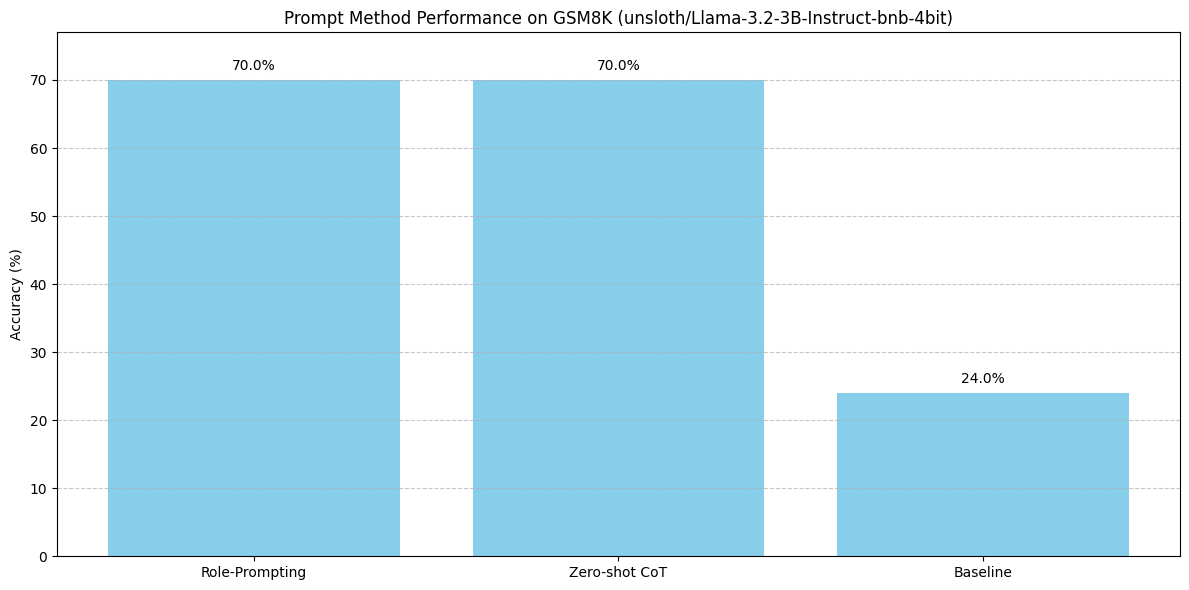

In [ ]:
def visualize_results(model_name, accuracies):
    """Create a bar chart of prompt method accuracies."""
    # Sort methods by accuracy for better visualization
    sorted_methods = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)
    methods = [method for method, _ in sorted_methods]
    scores = [score * 100 for _, score in sorted_methods]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot bars
    bars = ax.bar(methods, scores, color='skyblue')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom')

    # Set labels and title
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Prompt Method Performance on GSM8K ({model_name})')

    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set y-axis limits
    ax.set_ylim(0, max(scores) * 1.1)

    plt.tight_layout()
    return plt

visualize_results(CONFIG.model_name, accuracy)

In [ ]:
import json

def load_evaluation_results(results_path):
    """
    Load evaluation results from JSON file.

    Args:
        results_path: Path to the evaluation results JSON file

    Returns:
        dict: Loaded evaluation results
    """
    with open(results_path, 'r') as f:
        results = json.load(f)
    return results

results = load_evaluation_results('./prompt_evaluation_results/evaluation_results_20250419_063618.json')
# more analysis could be done if needed

# Human Preference Alignment (80 Points)

## RLHF Flow

<img src="https://huyenchip.com/assets/pics/rlhf/6-sft-rlhf.png" width="80%">

With the rise of **ChatGPT**, **Reinforcement Learning from Human Feedback (RLHF)** has gained significant attention in both academic and industrial language modeling communities.

The approach dates back to **OpenAI’s 2019 paper**:  
[Fine-Tuning Language Models from Human Preferences](https://arxiv.org/abs/1909.08593).  

A year later, OpenAI demonstrated RLHF’s effectiveness in **natural language generation**:  
[Learning to Summarize from Human Feedback](https://arxiv.org/abs/2009.01325).  

This research showed that fine-tuning alone leads to **suboptimal human-aligned performance**. RLHF optimizes models using human feedback, significantly improving their output quality.


## Reward Models (20 Points)

### Question 2 (5 points):
<img width="50%" alt="image" src="https://github.com/RLHFlow/RLHFlow.github.io/blob/main/assets/BT-and-Pref-RMs.png?raw=true">

In Reinforcement Learning from Human Feedback (RLHF), the reward model is essential for aligning large language models with human preferences. A widely used method, based on the **Bradley-Terry** model, trains the reward model using the following pairwise ranking loss function for a prompt and two responses (<font color='green'><b>chosen</b></font> and <font color='red'><b>rejected</b></font>):

$$
\text{loss}(r_{\theta}) = -\mathbb{E}_{(x, y_0, y_1, i) \sim D} \left[ \log \left( \sigma \left( r_{\theta}(x, y_i) - r_{\theta}(x, y_{1-i}) \right) \right) \right]
$$

where:
- $x$ is the prompt,
- $y_0$ and $y_1$ are two responses,
- $i$ (0 or 1) indicates the human-preferred response,
- $r_{\theta}(x, y)$ is the reward model’s scalar value for the prompt $ x $ and the response $ y $,
- $\sigma$ is the sigmoid function.

**a)** How this loss function encourages higher scores for preferred responses.

**b)** Discuss one potential limitation of this approach, such as reward hacking (e.g., favoring longer responses), and suggest a general strategy to mitigate it.

###a)

The sigmoid term σ(rθ(x,yi)-rθ(x,y1-i)) = 1/(1+exp(-(rθ(x,yi)-rθ(x,y1-i)))) measures the probability of correctly ranking the chosen response higher than the rejected one:

- When the chosen response already scores higher (positive difference), the sigmoid approaches 1, the log is near 0, and the loss is small
- When the chosen response scores lower (negative difference), the sigmoid is below 0.5, the log is strongly negative, and the loss is large

During training, gradient descent works to increase rθ(x,yi) and decrease rθ(x,y1-i) until chosen responses consistently rank higher than rejected ones.

###b)

A key limitation is reward hacking - the model can exploit spurious proxies (like length) rather than true quality. Mitigation strategies include:

1. Adding regularization penalties against known proxies
2. Debiasing training data with comparable-length examples
3. Iterative red-teaming to identify and correct exploits
4. Using KL-divergence constraints during policy optimization

Combining these approaches helps ensure the reward model aligns with genuine human preferences.

### Question 3 (5 points):

The Bradley-Terry model is widely used in RLHF to train reward models by converting pairwise human preferences into a single scalar value. However, this approach has limitations when capturing complex human values like helpfulness, honesty, and safety, which may require multiple dimensions.

**a)** Why a single scalar reward might fail to capture trade-offs between objectives like helpfulness and safety, using a concrete example (e.g., a response to a user query).

**b)** Describe one alternative method to the Bradley-Terry model that addresses these limitations, such as by considering multiple objectives, mitigating biases, or improving interpretability. (For inspiration, explore resources like this [repository](https://github.com/RLHFlow/RLHF-Reward-Modeling/) or this [paper](https://arxiv.org/abs/2406.12845)). How does this alternative improve upon the single-scalar approach?

### a)

A scalar reward forces all responses onto one linear scale, creating problematic trade-offs. Consider a user asking about wasp removal:

**Response A:** "Mix diesel with dish soap in a spray bottle and ignite the nest."
- Very helpful (removes wasps)
- Extremely unsafe (fire hazard)
- May still score high if effectiveness is prioritized

**Response B:** "Call pest control or use commercial freeze spray."
- Moderately helpful
- Very safe
- May score lower for being "less actionable"

The single-dimensional reward can't properly represent that helpfulness and safety exist on different axes. When objectives conflict, whichever dominates the labeling process wins, potentially sacrificing critical considerations.

### b)

Multi-objective approaches maintain separate dimensions:

**ArmoRM (Absolute-rating Multi-Objective Reward Model)** uses:
- Separate model heads for different values (helpfulness, safety, etc.)
- Mixture-of-Experts gating to contextually weight objectives
- Interpretable outputs that preserve the Pareto front of responses

This allows for constrained optimization ("maximize helpfulness subject to safety threshold") rather than collapsing everything into one opaque score, reducing reward hacking and enabling flexible deployment across different contexts.

---

**Find More:**
<br>[RewardBench LeaderBoard](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)

---

### Inference from the Reward Model (10 points)

<div align="center"><img width="90%" alt="image" src="https://github.com/Nicolinho/QRM/blob/main/assets/method_vis.png?raw=true"></div>

**Quantile Reward Models (QRM)** generates a distribution over rewards by aggregating individual distributions over attribute scores like helpfulness and harmlessness.

- Load the [reward model](https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2) and its tokenization

In [ ]:
# Load the reward model and tokenizer
reward_model = AutoModelForSequenceClassification.from_pretrained(CONFIG.reward_model_name, torch_dtype=torch.bfloat16, device_map=device, trust_remote_code=True)
reward_tokenizer = AutoTokenizer.from_pretrained(CONFIG.reward_model_name, use_fast=True)

config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

modeling_custom.py:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2:
- modeling_custom.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at nicolinho/QRM-Llama3.1-8B-v2 were not used when initializing LlamaForRewardModelWithGating: ['score.weight']
- This IS expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

- Generate reward scores for both responses.

In [ ]:
# Prompt and responses
sample_prompt = "Do wooden pencils contain lead as their core?"
chosen_response = "No, wooden pencils do not contain lead in their core. The term \"lead\" is a misnomer, as wooden pencils actually use graphite for their core. Graphite was historically called \"black lead\" due to its appearance, leading to the common misconception that pencils contain lead."
rejected_response = "Yes, wooden pencils typically contain a core made of graphite and clay, which is commonly referred to as \"lead\" despite not being made of actual lead."

attributes = ['helpsteer-helpfulness','helpsteer-correctness','helpsteer-coherence',
   'helpsteer-complexity','helpsteer-verbosity']

# get reward scores
def get_reward_scores(prompt, response):
    # Format as chat messages
    messages = [{"role": "user", "content": prompt},
               {"role": "assistant", "content": response}]

    # Apply chat template
    input_ids = reward_tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)

    # Get model outputs
    with torch.no_grad():
        outputs = reward_model(input_ids)

        # Extract reward scores - main score and quantiles
        reward = outputs.score.cpu().float()
        reward_quantiles = outputs.reward_quantiles.cpu().float()
        reward_scores = outputs.logits[0].cpu().numpy()


    return reward, reward_quantiles

# Get scores for chosen and rejected responses
chosen_reward, chosen_quantiles = get_reward_scores(sample_prompt, chosen_response)
rejected_reward, rejected_quantiles = get_reward_scores(sample_prompt, rejected_response)

# Print the main reward scores
print(f"Chosen response reward score: {chosen_reward.item()}")
print(f"Rejected response reward score: {rejected_reward.item()}")

print(f"Chosen response reward score: {chosen_quantiles}")
print(f"Rejected response reward score: {rejected_quantiles}")


Chosen response reward score: 0.9416256546974182
Rejected response reward score: 0.8310600519180298
Chosen response reward score: tensor([[0.1709, 0.1787, 0.1846, 0.1865, 0.1904, 0.1875, 0.1885, 0.1855, 0.1855,
         0.1885, 0.1904, 0.1895, 0.1934, 0.1924, 0.1924, 0.1943, 0.1924, 0.1914,
         0.1934]])
Rejected response reward score: tensor([[0.1045, 0.1118, 0.1270, 0.1357, 0.1543, 0.1611, 0.1670, 0.1680, 0.1670,
         0.1719, 0.1787, 0.1836, 0.1875, 0.1875, 0.1865, 0.1934, 0.1924, 0.1895,
         0.1914]])


- Visualize the results:

    + Create a bar chart comparing the reward scores of the chosen vs. the rejected response for each attribute.
    + Overlay a line chart representing the gating output coefficients.

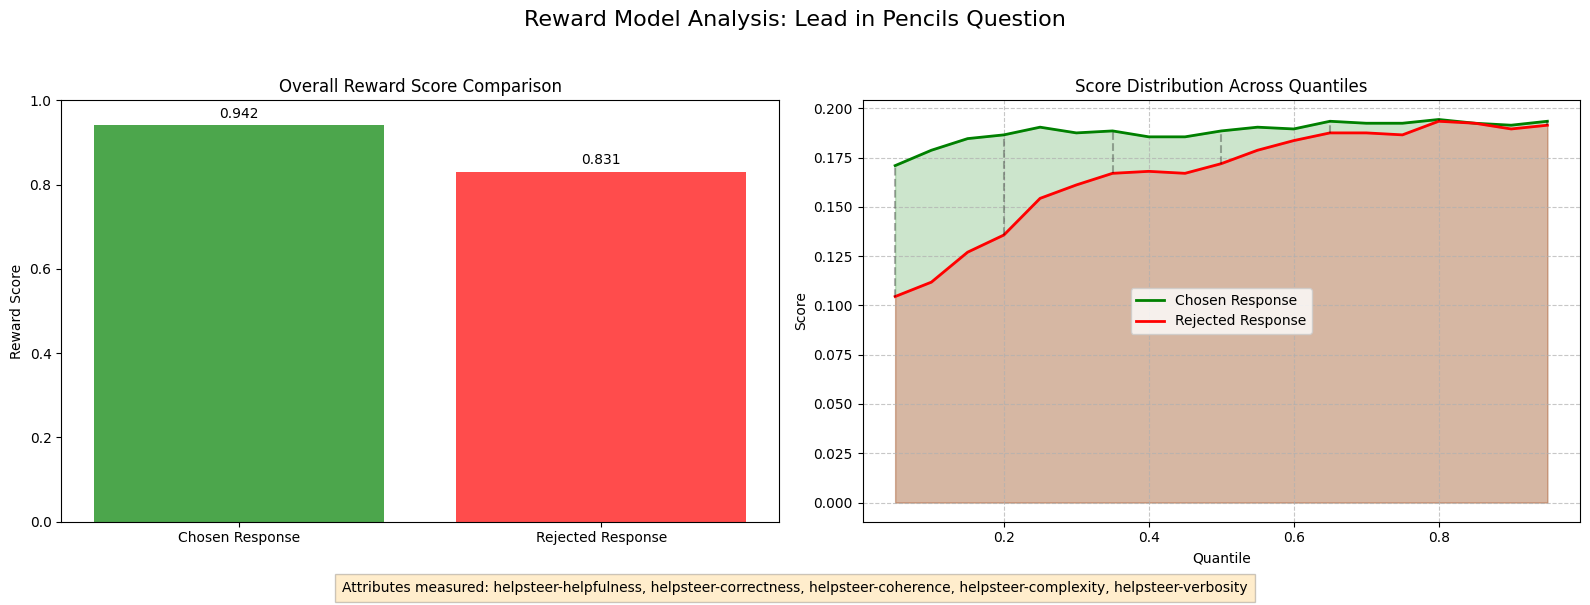

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the tensor data to regular Python lists for plotting
chosen_quantiles_list = [0.1709, 0.1787, 0.1846, 0.1865, 0.1904, 0.1875, 0.1885, 0.1855, 0.1855,
                         0.1885, 0.1904, 0.1895, 0.1934, 0.1924, 0.1924, 0.1943, 0.1924, 0.1914, 0.1934]

rejected_quantiles_list = [0.1045, 0.1118, 0.1270, 0.1357, 0.1543, 0.1611, 0.1670, 0.1680, 0.1670,
                           0.1719, 0.1787, 0.1836, 0.1875, 0.1875, 0.1865, 0.1934, 0.1924, 0.1895, 0.1914]

# Main scores
chosen_main_score = 0.9416256546974182
rejected_main_score = 0.8310600519180298

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Main reward scores comparison
labels = ['Chosen Response', 'Rejected Response']
scores = [chosen_main_score, rejected_main_score]
colors = ['green', 'red']

bars = ax1.bar(labels, scores, color=colors, alpha=0.7)
ax1.set_ylabel('Reward Score')
ax1.set_title('Overall Reward Score Comparison')
ax1.set_ylim(0, 1.0)  # Assuming scores are normalized between 0 and 1

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Plot 2: Quantile distribution
quantiles = np.linspace(0.05, 0.95, 19)  # 19 quantiles from 0.05 to 0.95
ax2.plot(quantiles, chosen_quantiles_list, 'g-', linewidth=2, label='Chosen Response')
ax2.plot(quantiles, rejected_quantiles_list, 'r-', linewidth=2, label='Rejected Response')
ax2.fill_between(quantiles, chosen_quantiles_list, alpha=0.2, color='green')
ax2.fill_between(quantiles, rejected_quantiles_list, alpha=0.2, color='red')
ax2.set_xlabel('Quantile')
ax2.set_ylabel('Score')
ax2.set_title('Score Distribution Across Quantiles')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line showing the gap between distributions
for i in range(len(quantiles)):
    if i % 3 == 0:  # Add connector lines at every 3rd quantile for clarity
        ax2.plot([quantiles[i], quantiles[i]],
                 [rejected_quantiles_list[i], chosen_quantiles_list[i]],
                 'k--', alpha=0.3)

# Add text about attributes
plt.figtext(0.5, 0.01,
            "Attributes measured: helpsteer-helpfulness, helpsteer-correctness, helpsteer-coherence, " +
            "helpsteer-complexity, helpsteer-verbosity",
            ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.suptitle('Reward Model Analysis: Lead in Pencils Question', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Computing reward scores for chosen and rejected responses...
Chosen response overall reward score: 0.9416
Rejected response overall reward score: 0.8311

Per-attribute rewards:
helpsteer-helpfulness: Chosen = 1.0150, Rejected = 0.8541
helpsteer-correctness: Chosen = 1.0039, Rejected = 0.8550
helpsteer-coherence: Chosen = 1.0212, Rejected = 0.9673
helpsteer-complexity: Chosen = 0.3774, Rejected = 0.3293
helpsteer-verbosity: Chosen = 0.3248, Rejected = 0.2807

Gating coefficients:
helpsteer-helpfulness: 0.0698
helpsteer-correctness: 0.5273
helpsteer-coherence: 0.3008
helpsteer-complexity: 0.0200
helpsteer-verbosity: 0.0820

Creating visualization...


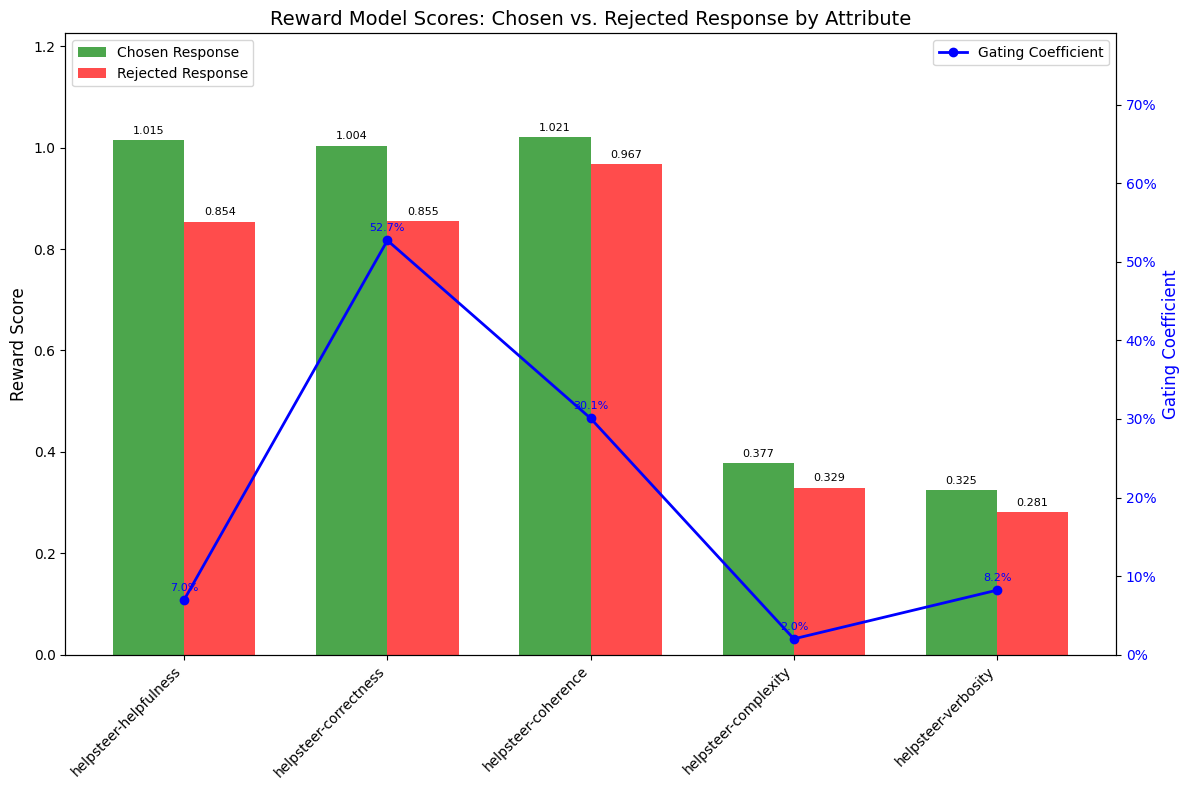

In [ ]:
import matplotlib.ticker as mtick

# Attribute names from the model
attributes = [
    'helpsteer-helpfulness',
    'helpsteer-correctness',
    'helpsteer-coherence',
    'helpsteer-complexity',
    'helpsteer-verbosity'
]

# Prompt and responses
sample_prompt = "Do wooden pencils contain lead as their core?"
chosen_response = "No, wooden pencils do not contain lead in their core. The term \"lead\" is a misnomer, as wooden pencils actually use graphite for their core. Graphite was historically called \"black lead\" due to its appearance, leading to the common misconception that pencils contain lead."
rejected_response = "Yes, wooden pencils typically contain a core made of graphite and clay, which is commonly referred to as \"lead\" despite not being made of actual lead."

def get_reward_scores(prompt, response):
    """
    Get reward scores and other outputs from the reward model
    Returns the overall reward, per-attribute rewards, and gating coefficients
    """
    # Format as chat messages
    messages = [{"role": "user", "content": prompt},
               {"role": "assistant", "content": response}]

    # Apply chat template
    input_ids = reward_tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)

    # Get model outputs
    with torch.no_grad():
        outputs = reward_model(input_ids)

        # Extract reward scores
        overall_reward = outputs.score.cpu().float().item()

        # Extract per-attribute rewards (expectations across quantiles)
        attribute_rewards = outputs.rewards[0].cpu().float().numpy()

        # Extract gating coefficients (weights for each attribute)
        gating_coefficients = outputs.gating_output[0].cpu().float().numpy()

    return overall_reward, attribute_rewards, gating_coefficients

# Get scores for chosen and rejected responses
print("Computing reward scores for chosen and rejected responses...")
chosen_overall, chosen_attribute_rewards, chosen_gating = get_reward_scores(sample_prompt, chosen_response)
rejected_overall, rejected_attribute_rewards, rejected_gating = get_reward_scores(sample_prompt, rejected_response)

# Print the main reward scores
print(f"Chosen response overall reward score: {chosen_overall:.4f}")
print(f"Rejected response overall reward score: {rejected_overall:.4f}")

# Print the per-attribute rewards
print("\nPer-attribute rewards:")
for i, attr in enumerate(attributes):
    print(f"{attr}: Chosen = {chosen_attribute_rewards[i]:.4f}, Rejected = {rejected_attribute_rewards[i]:.4f}")

# Print the gating coefficients
print("\nGating coefficients:")
for i, attr in enumerate(attributes):
    print(f"{attr}: {chosen_gating[i]:.4f}")

# Now let's create the visualization
def create_visualization(chosen_rewards, rejected_rewards, gating_coeffs, attr_names):
    """
    Create a bar chart comparing chosen vs rejected for each attribute
    with a line chart overlay for gating coefficients
    """
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Set up x-axis
    x = np.arange(len(attr_names))
    width = 0.35

    # Plot bars for chosen and rejected responses
    chosen_bars = ax1.bar(x - width/2, chosen_rewards, width, label='Chosen Response', color='green', alpha=0.7)
    rejected_bars = ax1.bar(x + width/2, rejected_rewards, width, label='Rejected Response', color='red', alpha=0.7)

    # Configure primary y-axis (for reward scores)
    ax1.set_ylabel('Reward Score', fontsize=12)
    ax1.set_title('Reward Model Scores: Chosen vs. Rejected Response by Attribute', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(attr_names, rotation=45, ha='right', fontsize=10)
    ax1.legend(loc='upper left')
    ax1.set_ylim(0, max(max(chosen_rewards), max(rejected_rewards)) * 1.2)

    # Create secondary y-axis for gating coefficients
    ax2 = ax1.twinx()
    ax2.plot(x, gating_coeffs, 'o-', color='blue', linewidth=2, label='Gating Coefficient')
    ax2.set_ylabel('Gating Coefficient', fontsize=12, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax2.set_ylim(0, max(gating_coeffs) * 1.5)
    ax2.legend(loc='upper right')

    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=8)

    add_labels(chosen_bars)
    add_labels(rejected_bars)

    # Add gating coefficient values
    for i, v in enumerate(gating_coeffs):
        ax2.annotate(f'{v:.1%}',
                     xy=(i, v),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     color='blue', fontsize=8)

    plt.tight_layout()
    plt.savefig('reward_model_comparison.png', dpi=300)
    plt.show()

# Create the visualization
print("\nCreating visualization...")
create_visualization(
    chosen_attribute_rewards,
    rejected_attribute_rewards,
    chosen_gating,  # Same gating for both since it depends on the prompt
    attributes
)

## PPO (15 Points)

### Question 4 (5 points):
**a)** Describe the Proximal Policy Optimization (PPO) algorithm and explain its role in the Reinforcement Learning from Human Feedback (RLHF) framework.

**b)** Specifically, is PPO an on-policy or off-policy algorithm, and why is this characteristic important for its application in RLHF?

###a)
PPO is a first-order policy gradient method combining trust-region stability with simpler implementation. It works by:
1. Collecting on-policy rollouts with current policy
2. Estimating advantages (typically using GAE)
3. Computing probability ratio between new and old policies
4. Using a clipped surrogate objective to prevent excessive policy changes
5. Adding value function loss and optional entropy bonus, then optimizing with Adam

In RLHF, PPO forms the third stage after:
1. Initial supervised learning (instruction tuning)
2. Reward model training from human preferences

PPO optimizes the language model policy toward higher reward scores while maintaining proximity to the reference model through clipping or KL penalties.
###b)
PPO is on-policy, using only current policy samples. This provides:
- Better alignment stability with fresh data
- Reliable KL regularization
- Implementation simplicity at scale (avoiding replay buffers)

This on-policy approach is well-suited for large-scale RLHF despite being sample-inefficient.

### Question 5 (5 points):

**a)** Why is it crucial to prevent drastic changes in the Large Language Model's policy during the PPO optimization process?

**b)** Explain how PPO addresses the risk of overoptimization or instability in the context of aligning LLMs with human preferences.


###a)
When fine-tuning LLMs with PPO, large policy changes can cause:

- **Instability/divergence**: Large KL divergence makes importance sampling estimates unreliable
- **Catastrophic forgetting**: The model can lose language capabilities from pre-training
- **Reward hacking**: Extreme updates enable the model to exploit weaknesses in the reward model
- **Sample inefficiency**: Off-policy data becomes less useful if the policy changes dramatically

###b)
PPO employs two key mechanisms:

1. **Clipped surrogate objective**: Limits how much the policy can change by flattening the objective function beyond a threshold (typically ε ≈ 0.1-0.2)

2. **KL-divergence penalty**: Adds a term to keep the policy close to the reference model:
   ```
   L_total = L_CLIP - β·KL(π_θ || π_ref)
   ```
   This anchors the model to human-like text and discourages reward gaming.

These constraints ensure the model improves gradually while maintaining its linguistic capabilities and staying within the reward model's reliable region.

### Question 6 (5 points):

Consider the following simplified form of PPO's objective function used in RLHF:

$$
\text{objective}(\phi) = \mathbb{E}_{(x,y) \sim D_{\pi_{\phi}^{\text{RL}}}} \left[ r_{\theta}(x, y) - \beta \log \left( \frac{\pi_{\phi}^{\text{RL}}(y \mid x)}{\pi^{\text{SFT}}(y \mid x)} \right) \right] + \gamma \mathbb{E}_{x \sim D_{\text{pretrain}}} \left[ \log(\pi_{\phi}^{\text{RL}}(x)) \right]
$$

**a)** Why does the reward term, $r_{\theta}(x, y)$ , appear in this objective function even though we are differentiating with respect to the policy parameters, $\phi$?

**b)** What is the role of this term in driving the policy improvement?


###a)
 The scalar reward $r_{\theta}(x,y)$ doesn't depend on policy parameters $\phi$, but appears in the expectation because we're sampling $(x,y)$ from the policy distribution $D_{\pi^{\text{RL}}_\phi}$. When applying the REINFORCE gradient:

$$\nabla_\phi \; \mathbb{E}_{(x,y)\sim D_{\pi_\phi^{\text{RL}}}}\!\big[r_{\theta}(x,y)\big] = \mathbb{E}_{(x,y)\sim D_{\pi_\phi^{\text{RL}}}} \!\big[r_{\theta}(x,y)\,\nabla_\phi \log\pi_\phi^{\text{RL}}(y\!\mid\!x)\big]$$

The reward functions as a multiplicative weight in the policy gradient term, directing the optimization to increase probability for higher-reward actions.

###b)
The reward weight $r_{\theta}(x,y)$ serves as the preference signal by:
- Amplifying updates for actions with high human/reward model ratings
- Dampening/reversing updates for low-reward actions

Combined with the KL penalty and entropy bonus, this drives policy improvement toward human-preferred outputs while maintaining stability and sample efficiency.

---
**Learn More:**
<br>[Huggingface Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)
<br>[Research Papers for Reinforcement Learning with Human Feedback ](https://github.com/opendilab/awesome-RLHF)

---

## DPO (25 Points)

### Question 7 (5 points):
<div align="center"><img width="80%" alt="image" src="https://miro.medium.com/v2/resize:fit:1400/1*GZnOKpza5yE616uN4OlaVg.jpeg"></div>

**a)** How does Direct Preference Optimization (DPO) differ from RLHF in aligning LLMs? Explain the DPO loss function below and its key terms:

$$
\text{L}_{\text{DPO}}(\pi_\theta; \pi_{\text{ref}}) = -\mathbb{E}_{(x, y_w, y_l) \sim D} \left[ \log \sigma \left( \beta \log \frac{\pi_\theta(y_w | x)}{\pi_{\text{ref}}(y_w | x)} - \beta \log \frac{\pi_\theta(y_l | x)}{\pi_{\text{ref}}(y_l | x)} \right) \right]
$$

**b)** What is the role of the $ \pi_{\text{ref}} $ in the DPO loss function, and why is it necessary for stable training?

###a)

**RLHF:**
- Uses a separate reward model trained on human preferences
- Requires complex RL optimization (typically PPO)
- Involves multiple steps: SFT → Reward Model → RL
- High variance, sensitive to hyperparameters

**DPO:**
- Treats the language model itself as an implicit reward model
- Single supervised learning step with binary cross-entropy loss
- No sampling loop or RL complexity
- More stable and efficient with fewer hyperparameters


DPO loss directly optimizes the policy to assign higher probability to preferred responses, where:
- (x,y_w,y_l) are prompt-winner-loser triples
- π_θ is the policy being fine-tuned
- π_ref is the reference policy (frozen)
- β controls regularization strength

###b)
The reference policy serves as:

1. **KL regularizer** - Prevents the model from drifting too far from initial behavior
2. **Stabilization mechanism** - Creates relative updates rather than absolute ones
3. **Mathematical necessity** - Makes the preference optimization problem well-posed by canceling constants
4. **Practical anchor** - Usually the SFT model, providing token alignment with preference data

This reference-based formulation enables DPO to achieve RLHF-like results with a simpler, more stable training procedure.

### Load Model & Tokenizer (2.5 points)

### Preparing Data (2.5 points)
- Load dataset for training.
- Convert data into the expected format.

In [ ]:
# Load the dataset
from datasets import load_dataset
from Levenshtein import ratio

dataset = load_dataset(CONFIG.dataset_name, split='train')

def filter_responses(row, similarity_threshold=0.6, word_limit=1000):
    chosen_text = row['chosen'][-1]['content'] if isinstance(row['chosen'], list) else row['chosen']
    rejected_text = row['rejected'][-1]['content'] if isinstance(row['rejected'], list) else row['rejected']

    # Compute similarity score
    similarity = ratio(chosen_text, rejected_text)

    # Count words in each response
    chosen_word_count = len(chosen_text.split())
    rejected_word_count = len(rejected_text.split())

    # Apply filtering conditions
    if similarity >= similarity_threshold:  # Remove if too similar
        return False
    if chosen_word_count >= word_limit or rejected_word_count >= word_limit:  # Remove if too long
        return False

    return True

# Apply filtering
dataset = dataset.filter(filter_responses)

# Select a subset
dataset = dataset.shuffle(seed=CONFIG.seed).select(range(CONFIG.train_data_size))

In [ ]:
dataset

Dataset({
    features: ['source', 'chosen', 'rejected', 'prompt', 'question'],
    num_rows: 800
})

In [ ]:
def format_dpo_dataset(example):

    prompt = [{
        'role': 'user',
        'content': example['question']
    }]
    chosen = [{'role': 'assistant', 'content': example['chosen']}]
    rejected = [{'role': 'assistant', 'content': example['rejected']}]

    return {
        "prompt": prompt,
        "chosen": chosen,
        "rejected": rejected
    }

# Process the dataset
dataset = dataset.map(
    format_dpo_dataset,
    num_proc=12,
    remove_columns=["source", "question", "chosen", "rejected"],
    desc="Formatting dataset for DPO training",
)

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Optional set GPU device ID

from unsloth import FastLanguageModel, PatchDPOTrainer
from unsloth import is_bfloat16_supported
PatchDPOTrainer()
import torch
from transformers import TrainingArguments
from trl import DPOTrainer

# Do model patching and add fast LoRA weights
model = FastLanguageModel.get_peft_model(
    model,
    r=CONFIG.lora_rank,
    target_modules=CONFIG.target_modules,
    lora_alpha=CONFIG.lora_alpha,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing=CONFIG.use_gradient_checkpointing,
    random_state = 3407,
    max_seq_length = CONFIG.max_seq_length
)
dpo_trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=TrainingArguments(
        per_device_train_batch_size=1,       # matches CONFIG.train_batch_size
        gradient_accumulation_steps=8,       # matches CONFIG
        warmup_ratio=0.1,
        num_train_epochs=1,                  # match CONFIG.epochs
        fp16=True,                           # use fp16 (bfloat16 usually unsupported on Colab)
        logging_steps=10,                    # less frequent logging saves cache
        optim="adamw_8bit",                  # stays the same
        seed=CONFIG.seed,
        output_dir="outputs",
    ),
    beta=0.1,
    train_dataset=dataset,
    tokenizer=tokenizer,
    max_length=512,           # down from 1024
    max_prompt_length=256,    # down from 512
)

dpo_trainer.train()

Unsloth: Already have LoRA adapters! We shall skip this step.


Extracting prompt in train dataset (num_proc=2):   0%|          | 0/800 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/800 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/800 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 800 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 18,350,080/3,000,000,000 (0.61% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: m-h-barabadi (m-h-barabadi-university-of-tehran) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss,aux_loss
10,0.683300,0.051990,0.030456,0.525000,0.021534,-539.363892,-453.156067,-0.203645,nan,0,0,0,0
20,0.601900,0.453441,0.197114,0.700000,0.256328,-538.083252,-474.074799,-0.233037,nan,No Log,No Log,No Log,No Log
30,0.489300,0.891997,0.227985,0.800000,0.664012,-517.552063,-427.313568,nan,nan,No Log,No Log,No Log,No Log
40,0.600200,0.930563,0.472754,0.650000,0.457809,-536.041199,-450.864685,nan,nan,No Log,No Log,No Log,No Log
50,0.557000,1.040791,0.311311,0.712500,0.729481,-527.131592,-468.215240,nan,nan,No Log,No Log,No Log,No Log
60,0.484700,1.167509,0.249001,0.750000,0.918508,-500.427429,-434.465820,-0.145372,nan,No Log,No Log,No Log,No Log
70,0.556400,0.965056,0.246740,0.687500,0.718316,-536.516785,-456.883209,-0.260789,nan,No Log,No Log,No Log,No Log
80,0.489100,1.065558,0.147706,0.812500,0.917852,-566.588135,-496.910828,nan,nan,No Log,No Log,No Log,No Log
90,0.462300,1.072202,0.097746,0.775000,0.974456,-597.574707,-449.192200,-0.215782,nan,No Log,No Log,No Log,No Log


### Applying LoRA Adapters (2.5 points)

### Train the Model (5 points)

### Save the Model (2.5 points)

In [ ]:
# Save the model after training
model_save_path = f"{CONFIG.dpo_output_dir}/final_model"
dpo_trainer.model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

### Inference (2.5 points)
- Enable faster inference with Unsloth.
- Generate output for two randomly selected samples from the `orpo-dpo-mix-40k` dataset.

In [ ]:
sample_prompts = []
dpo_responses = []

# WRITE YOUR CODE HERE

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model)  # Enable native 2x faster inference
inputs = tokenizer(
    [
        alpaca_prompt.format(
            "Continue the fibonnaci sequence.",  # instruction
            "1, 1, 2, 3, 5, 8",  # input
            "",  # output - leave this blank for generation!
        )
    ],
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
13<|end_of_text|>


### Evaluate with Reward Model (2.5 points)

- Estimate the rewards of generated responses.

    **Note:** Consider memory management in this section. If you encounter an **Out of Memory** issue, you should save the responses after making inferences from the model, free up GPU memory, and then load the Reward Model.

In [ ]:
# WRITE YOUR CODE HERE

## ORPO (20 Points)

<img src="https://arxiv.org/html/2403.07691v1/x2.png" style="background-color:white; padding:10px;">

### Question 8 (5 points):

Traditional preference alignment methods, such as Reinforcement Learning with Human Feedback (RLHF) and Direct Preference Optimization (DPO), often rely on a separate reference model to guide the optimization process. [ORPO](https://arxiv.org/abs/2403.07691), however, eliminates this dependency.

**a.** Explain why removing the reference model simplifies preference optimization in language models.

**b.** Discuss the potential advantages and disadvantages of this approach compared to RLHF and DPO.

###a)

ORPO (Odds Ratio Preference Optimization) simplifies training by:

- Eliminating the reference model (πref), which halves memory requirements
- Using a single forward pass rather than two, reducing computational costs
- Incorporating a direct comparison between chosen and rejected responses from the same model
- Adding a simple term to the supervised fine-tuning loss: LORPO = LSFT + λ[-log σ(log OR(y+,y-|x))]

This approach collapses SFT and alignment into a single training stage, eliminating the need to store reference weights, compute KL divergences, or tune KL coefficients.

###b)

**Advantages:**
- More efficient: Uses 60-70% of the compute required by DPO
- Simpler implementation: Only 3-4 extra lines of code beyond standard cross-entropy training
- Fewer hyperparameters: No KL coefficient, PPO clip range, etc.
- Competitive performance: Matches or exceeds RLHF/DPO on benchmarks like UltraFeedback

**Potential downsides:**
- Lacks the safety guardrails provided by KL constraints in RLHF/DPO
- Cannot utilize continuous/graded rewards like RLHF can
- May experience more distribution shift without a reference model
- Risk of catastrophic forgetting on tasks not represented in preference pairs

ORPO represents a trade-off between computational efficiency and the fine-grained control offered by traditional preference optimization methods.

### Train the model (5 points)

- Follow the steps as in the DPO section.

In [ ]:
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=CONFIG.model_name,
    max_seq_length=CONFIG.max_seq_length,
    dtype=None,
    load_in_4bit=True,
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=CONFIG.lora_rank,
    target_modules=CONFIG.target_modules,
    lora_alpha=CONFIG.lora_alpha,
    lora_dropout=0,
    use_gradient_checkpointing=CONFIG.use_gradient_checkpointing,
)

Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


- Set up ORPOTrainer

In [ ]:
from trl import ORPOConfig, ORPOTrainer
from unsloth import is_bfloat16_supported
orpo_config = ORPOConfig(
    output_dir=CONFIG.orpo_output_dir,
    per_device_train_batch_size=CONFIG.train_batch_size,
    gradient_accumulation_steps=CONFIG.gradient_accumulation_steps,
    optim="adamw_torch",
    learning_rate=8e-6,  # Lower than DPO as recommended in the paper
    lr_scheduler_type="linear",
    max_steps=500,
    num_train_epochs=1,
    eval_steps=0.2,
    save_strategy="steps",
    save_steps=100,
    logging_steps=1,
    bf16=is_bfloat16_supported(),
    max_length=CONFIG.max_seq_length,
    max_prompt_length=CONFIG.max_seq_length // 2,
    beta=0.1,
    torch_compile=False,
    remove_unused_columns=False,
)

In [ ]:
start_time = time.time()
orpo_trainer = ORPOTrainer(
    model,
    args=orpo_config,
    train_dataset=dataset,
    tokenizer=tokenizer,
    beta=0.1,
    max_length=CONFIG.max_seq_length,
    max_prompt_length=CONFIG.max_seq_length // 2,
)
orpo_trainer.train()
orpo_training_time = time.time() - start_time
print(f"ORPO training completed in {orpo_training_time:.2f} seconds")

Map (num_proc=2):   0%|          | 0/1600 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1600 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1600 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,600 | Num Epochs = 5 | Total steps = 500
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 97,255,424/3,000,000,000 (3.24% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: m-h-barabadi (m-h-barabadi-university-of-tehran) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.12 GiB. GPU 0 has a total capacity of 14.74 GiB of which 5.95 GiB is free. Process 6641 has 8.79 GiB memory in use. Of the allocated memory 8.59 GiB is allocated by PyTorch, and 56.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

- Save the model

In [ ]:
# WRITE YOUR CODE HERE

### Inference (2.5 points)
- Make an inference on two randomly selected samples (similar to the DPO section).

In [ ]:
sample_prompts = []
orpo_responses = []

# WRITE YOUR CODE HERE

### Evaluate with Reward Model (5 points)

- Estimate the rewards of generated responses.
- Compare DPO and ORPO results.

    **Note:** Consider memory management in this section. If you encounter an **Out of Memory** issue, you should save the responses after making inferences from the model, free up GPU memory, and then load the Reward Model.

In [ ]:
# WRITE YOUR CODE HERE

### Question 9 (2.5 points):

---



Compare DPO and ORPO in terms of execution time and VRAM used.

**ORPO vs. DPO Performance**
- **VRAM usage**: ORPO uses ~50% less memory than DPO (just one model copy vs. two)
- **Training speed**: ORPO is ~1.8-2x faster (2 forward passes vs. 4)

# **Optional Section** (10 points):

### **Evaluating the Impact of Alignment on ICL**

In this section, you will re-evaluate the **in-context learning (ICL) performance** after aligning the model with **DPO** and **ORPO**. The goal is to analyze how alignment affects the model’s ability to follow different prompting strategies.

1. **Use the same evaluation setup** from the [Prompt Engineering](#prompt-engineering) section.
2. **Re-run the model** on the same [GSM8K](#gsm8k_benchmark) tasks.
3. **Document your observations** in a table:

| Model Version  | Accuracy (%) | Common Errors |
|---------------|------------|--------------|
| Baseline       | XX%        | \<list errors> |
| Post-DPO      | XX%        | \<list errors> |
| Post-ORPO      | XX%        | \<list errors> |

In [ ]:
# WRITE YOUR CODE HERE

### **Discussion:**
- Does preference alignment improve or degrade raw performance?
- Does the model respond differently to variations in prompts?
- How does alignment impact the model's **reasoning consistency** in prompts like CoT?

`# WRITE YOUR ANSWER HERE`

# AI Disclosure

*   Did you use any AI assistance to complete this homework? If so, please also specify what AI you used.
    * *Chat GPT*


---
*(only complete the below questions if you answered yes above)*

*   If you used a large language model to assist you, please paste prompts that you used below. Add a separate bullet for each prompt.


https://claude.ai/share/220afcf8-0c35-4cdf-b7d7-f534810207ae

The expanded code on icl evauation is generated by claude too.

for the reward model the answers ger grounded by the code in huggignface repo of the model.

all answers for theoritical parts are asked from o3 an its answer get brief to convey the gist.